In [1]:
import pandas as pd

In [2]:
data = pd.read_excel('metadata/spine_density_hum_and_mouse-20231101.xlsx')
data = data.rename(columns=dict(zip(data.columns, list('ABCDEFGHIJKLMNOPQRSTUV')[0:8])))

In [3]:
mdens = data.loc[3:18, ['A', 'B', 'C', 'D']]
mdens.columns=['distance', 'mean', 'std', 'sem']
mdens = mdens.astype(float)

In [4]:
hdens = data.loc[3:25, ['A', 'F', 'G', 'H']]
hdens.columns=['distance', 'mean', 'std', 'sem']
hdens = hdens.astype(float)

In [5]:
data_new = pd.read_excel('metadata/spine_density_new_data_mouse-20240419.xlsx')
data_new = data_new.rename(columns=dict(zip(data_new.columns, list('ABCDEFGHIJKLMNOPQRSTUVWXYZ') + ['AA', 'AB'])))

In [6]:
mdens_old = data_new.loc[3:21, ['C', 'H', 'I', 'J']]
mdens_old.columns=['distance', 'mean', 'std', 'sem']
mdens_old = mdens_old.astype(float)

In [7]:
mdens_new = data_new.loc[3:21, ['M', 'Z', 'AA', 'AB']]
mdens_new.columns=['distance', 'mean', 'std', 'sem']
mdens_new = mdens_new.astype(float)

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
Set1 = mpl.colormaps['Set1']
Pastel1 = mpl.colormaps['Pastel1']
mcolor = Set1(0.0)
hcolor = Set1(1.0/9)
mcolor_light = Pastel1(0.0)
hcolor_light = Pastel1(1.0/9)

In [10]:
from scipy.optimize import curve_fit

In [11]:
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-(x - b) / c))

In [12]:
def linsigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-(x - b) / c)) * (1 - (x - b) / d)

In [13]:
def expsigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-(x - b) / c)) * np.exp(-(x - b) / d)

Mouse a=1.6303593875826843, b=37.084155509669145, c=4.2069882964020495
Human a=0.7182570457057172, b=43.01995596246957, c=3.8928549708016957


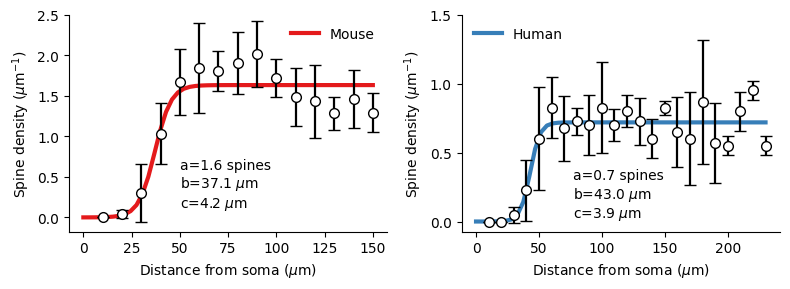

In [14]:
fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 2, 1)

xdata = mdens_new['distance'].iloc[:-1]
ydata = mdens_new['mean'].iloc[:-1]
a, b, c, d = 10, 45, 10, 100
#mpopt, _ = curve_fit(linsigmoid, xdata, ydata, p0=(a,b,c,d))
#a, b, c, d = mpopt
mpopt, _ = curve_fit(sigmoid, xdata, ydata, p0=(a,b,c))
a, b, c = mpopt
x = np.linspace(0, max(xdata))
#y = linsigmoid(x, *mpopt)
y = sigmoid(x, *mpopt)
#print(f'Mouse {a=}, {b=}, {c=}, {d=}')
print(f'Mouse {a=}, {b=}, {c=}')

ax.plot(x, y, color=mcolor, linewidth=3, label='Mouse')
ax.errorbar(mdens_new['distance'].iloc[:-1], mdens_new['mean'].iloc[:-1], yerr=mdens_new['std'].iloc[:-1], 
            linestyle='', marker='o', markersize=7, markerfacecolor='w', capsize=4,
            linewidth=3, elinewidth=1.6, color='black')
#ax.text(max(xdata)/3, max(ydata)/5, f"{a=:.1f} spines\n{b=:.1f} $\mu$m\n{c=:.1f} $\mu$m\n{d=:.0f} $\mu$m", va='center')
ax.text(max(xdata)/3, max(ydata)/5, f"{a=:.1f} spines\n{b=:.1f} $\mu$m\n{c=:.1f} $\mu$m", va='center')

ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('Spine density ($\mu$m$^{-1}$)')
ax.set_xlabel('Distance from soma ($\mu$m)')
ax.set_yticks([0,.5,1,1.5,2,2.5])
ax.set_ylim(top=2.5)
ax.legend(frameon=False)

ax = fig.add_subplot(1, 2, 2)

xdata = hdens['distance']
ydata = hdens['mean'] / 10
#hpopt, _ = curve_fit(linsigmoid, xdata, ydata, p0=(a,b,c,d))
#a, b, c, d = hpopt
hpopt, _ = curve_fit(sigmoid, xdata, ydata, p0=(a,b,c))
a, b, c = hpopt
x = np.linspace(0, max(xdata))
#y = linsigmoid(x, *hpopt)
#print(f'Human {a=}, {b=}, {c=}, {d=}')
y = sigmoid(x, *hpopt)
print(f'Human {a=}, {b=}, {c=}')

ax.plot(x, y, color=hcolor, linewidth=3, label='Human')
ax.errorbar(hdens['distance'], hdens['mean']/10, yerr=hdens['std']/10, 
            linestyle='', marker='o', markersize=7, markerfacecolor='w', capsize=4,
            linewidth=3, elinewidth=1.6, color='black')
#ax.text(max(xdata)/3, max(ydata)/5, f"{a=:.1f} spines\n{b=:.1f} $\mu$m\n{c=:.1f} $\mu$m\n{d=:.0f} $\mu$m", va='center')
ax.text(max(xdata)/3, max(ydata)/5, 
        f"{a=:.1f} spines\n{b=:.1f} $\mu$m\n{c=:.1f} $\mu$m", 
        va='center')

ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('Spine density ($\mu$m$^{-1}$)')
ax.set_xlabel('Distance from soma ($\mu$m)')
ax.set_yticks([0,.5,1,1.5])
ax.set_ylim(top=1.5)
ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('images/spine-compare-1.pdf')

In [15]:
import json

densityfit = {}
densityfit['Mouse'] = mpopt.tolist()
densityfit['Human'] = hpopt.tolist()

with open('metadata/densityfit.json', 'w') as fp:
    json.dump(densityfit, fp)